<a href="https://colab.research.google.com/github/DB11051998/Pothole-Detection/blob/master/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd drive/My\ Drive/pothole

/content/drive/My Drive/pothole


In [ ]:
ls

annotated-images/  kernel53192baf7b.ipynb  README.md    Untitled0.ipynb
download.jpeg      Mask_RCNN/              splits.json


In [ ]:
#!pip install tensorflow==1.13.1


In [ ]:
%tensorflow_version 1.x

import tensorflow as tf
tf.__version__

TensorFlow 1.x selected.


'1.15.2'

In [ ]:
import numpy as np 
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold
import sys
import random
import math
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
DATA_DIR = '/content/drive/My Drive/pothole'
ROOT_DIR = '/content/drive/My Drive/pothole'

In [ ]:
#!git clone https://www.github.com/matterport/Mask_RCNN.git

In [ ]:
os.chdir('/content/drive/My Drive/pothole/Mask_RCNN')


In [ ]:
ls

assets/            README.md                sonu_cnfg20200628T1222/
images/            requirements.txt         sonu_cnfg20200628T1505/
LICENSE            samples/                 sonu_cnfg20200704T0420/
MANIFEST.in        setup.cfg                sonu_cnfg20200704T0654/
mask_rcnn_coco.h5  setup.py                 sonu_cnfg20200704T0657/
mrcnn/             sonu_cnfg20200628T1221/  sonu_cnfg20200704T0719/


In [ ]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.utils import Dataset
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

Using TensorFlow backend.


In [ ]:
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"


-rw------- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [ ]:
from xml.etree import ElementTree

# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

# extract details form annotation file
boxes, w, h = extract_boxes('/content/drive/My Drive/pothole/annotated-images/img-1.xml')
# summarize extracted details
print(boxes, w, h)


[[213, 240, 525, 378]] 720 720


In [ ]:
class PothholeData(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset, is_train=True):
        # define one class
        self.add_class("dataset", 1, "pothole")
        # define data locations
        images_dir = '/content/drive/My Drive/pothole/annotated-images/'
        annotations_dir = '/content/drive/My Drive/pothole/annotated-images/'
        # find all images
        for filename in dataset :
            # extract image id
            #image_id = filename[:-4]
            if '.xml' in filename:
                image_id=filename.replace('.xml','')[4:]
            # skip bad images
            #if image_id in ['00090']:
            #    continue
            # skip all images after 150 if we are building the train set
            #if is_train and int(image_id) >= 150:
            #    continue
            # skip all images before 150 if we are building the test/val set
            #if not is_train and int(image_id) < 150:
            #    continue
            if 'xml' in filename:
                #print(i.replace('xml','jpg'))
                img_path = images_dir + filename.replace('xml','jpg')
            ann_path = annotations_dir + filename
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks =np.zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('pothole'))
        return masks, np.asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [ ]:
import json

f=open('/content/drive/My Drive/pothole/splits.json',)
traindata=json.load(f)['train']


In [ ]:
f=open('/content/drive/My Drive/pothole/splits.json',)
testdata=json.load(f)['test']

In [ ]:
train_set = PothholeData()
train_set.load_dataset(traindata, is_train=True)

In [ ]:
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 532


In [ ]:
test_set = PothholeData()
test_set.load_dataset(testdata, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 133


In [ ]:
image_id = 200
image = train_set.load_image(image_id)
print(image.shape)

(720, 720, 3)


In [ ]:
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(720, 720, 2)


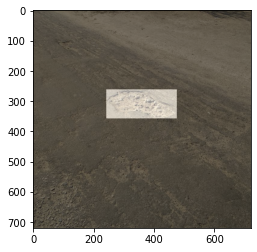

In [ ]:
plt.imshow(image)
# plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()


In [ ]:
for image_id in train_set.image_ids:
    # load image info
    info = train_set.image_info[image_id]
    # display on the console
    print(info)


{'id': '110', 'source': 'dataset', 'path': '/content/drive/My Drive/pothole/annotated-images/img-110.jpg', 'annotation': '/content/drive/My Drive/pothole/annotated-images/img-110.xml'}
{'id': '578', 'source': 'dataset', 'path': '/content/drive/My Drive/pothole/annotated-images/img-578.jpg', 'annotation': '/content/drive/My Drive/pothole/annotated-images/img-578.xml'}
{'id': '455', 'source': 'dataset', 'path': '/content/drive/My Drive/pothole/annotated-images/img-455.jpg', 'annotation': '/content/drive/My Drive/pothole/annotated-images/img-455.xml'}
{'id': '87', 'source': 'dataset', 'path': '/content/drive/My Drive/pothole/annotated-images/img-87.jpg', 'annotation': '/content/drive/My Drive/pothole/annotated-images/img-87.xml'}
{'id': '213', 'source': 'dataset', 'path': '/content/drive/My Drive/pothole/annotated-images/img-213.jpg', 'annotation': '/content/drive/My Drive/pothole/annotated-images/img-213.xml'}
{'id': '369', 'source': 'dataset', 'path': '/content/drive/My Drive/pothole/an

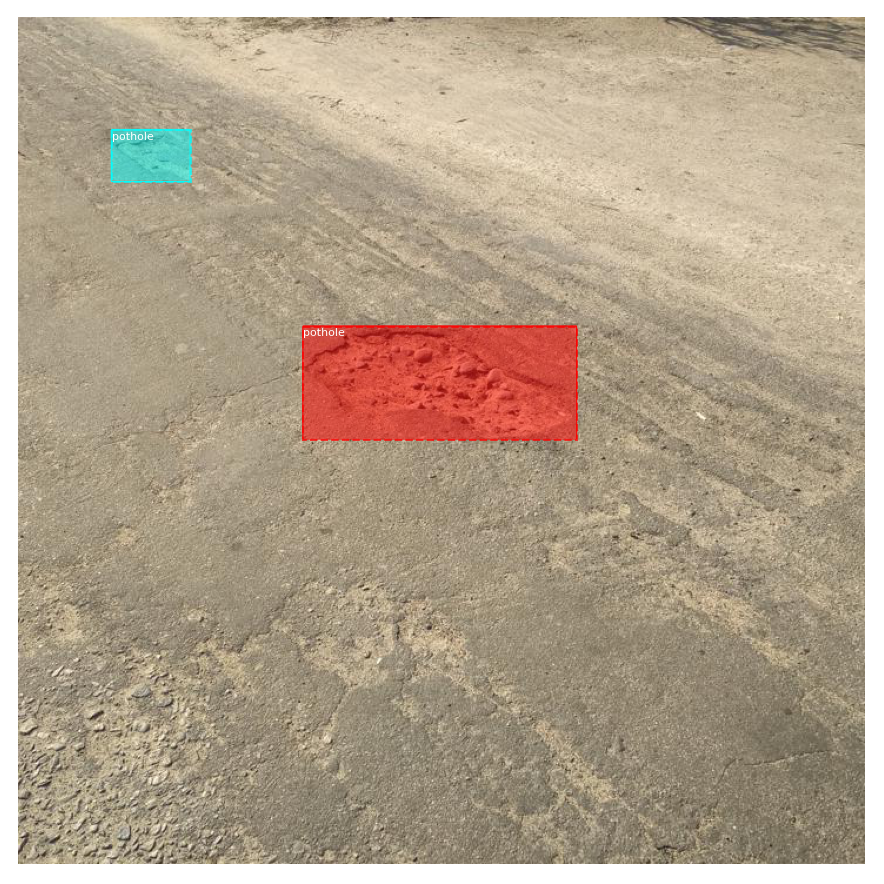

In [ ]:
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
 #define a configuration for the model
class Potholeconfig(Config):
    # Give the configuration a recognizable name
    NAME = "sonu_cnfg"
    #NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    #RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200


# prepare config
config = Potholeconfig()

In [ ]:
from mrcnn.model import MaskRCNN


In [ ]:
train_set.image_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
test_set.image_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132])

In [ ]:
#!pip install 'tensorflow-gpu==1.13.1'

In [ ]:
#positive_indices=[]
#try:
model = MaskRCNN(mode='training', model_dir='./', config=config)
#except AttributeError:
#positive_indices = tf.random.shuffle(positive_indices)[:positive_count]
    # load weights (mscoco) and exclude the output layers
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.keras_model.metrics_tensors = [] 
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE,epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./sonu_cnfg20200706T0800/mask_rcnn_sonu_cnfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeD

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
200/200 [==============================] - 782s 4s/step - loss: 2.2482 - val_loss: 1.8503

Epoch 2/5
200/200 [==============================] - 69s 346ms/step - loss: 1.7038 - val_loss: 1.3313
Epoch 3/5
200/200 [==============================] - 109s 547ms/step - loss: 1.5112 - val_loss: 1.1816
Epoch 4/5
200/200 [==============================] - 111s 557ms/step - loss: 1.3624 - val_loss: 1.9365
Epoch 5/5
200/200 [==============================] - 111s 557ms/step - loss: 1.2602 - val_loss: 1.6879


In [ ]:
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "sonu_cnfg"
	# number of classes (background + pothole)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [ ]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)



Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model.load_weights('/content/drive/My Drive/pothole/Mask_RCNN/sonu_cnfg20200706T0800/mask_rcnn_sonu_cnfg_0005.h5', by_name=True)


Re-starting from epoch 5


In [ ]:
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = np.expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = np.mean(APs)
	return mAP

In [ ]:
import pandas as pd

In [ ]:
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

NameError: ignored

In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample =np.expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		plt.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		plt.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Predicted')
		ax = plt.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	plt.show()

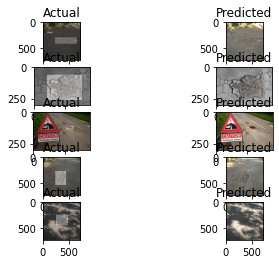

In [ ]:
plot_actual_vs_predicted(train_set, model, cfg)

In [ ]:
image = train_set.load_image(200)
mask, _ = train_set.load_mask(200)

In [ ]:
scaled_image = mold_image(image, cfg)
# convert image into one sample
sample =np.expand_dims(scaled_image, 0)
# make prediction
yhat = model.detect(sample, verbose=0)[0]

In [ ]:
yhat

{'class_ids': array([], dtype=int32),
 'masks': array([], shape=(720, 720, 0), dtype=float64),
 'rois': array([], shape=(0, 4), dtype=int32),
 'scores': array([], dtype=float32)}

array([[[[ 60.3,  54.2,  50.1],
         [ 52.3,  46.2,  42.1],
         [ 43.3,  37.2,  33.1],
         ...,
         [ 38.3,  25.2,   1.1],
         [ 36.3,  24.2,  -2.9],
         [ 35.3,  23.2,  -3.9]],

        [[ 52.3,  46.2,  42.1],
         [ 44.3,  38.2,  34.1],
         [ 36.3,  30.2,  26.1],
         ...,
         [ 37.3,  26.2,   1.1],
         [ 37.3,  26.2,   1.1],
         [ 35.3,  24.2,  -0.9]],

        [[ 45.3,  39.2,  35.1],
         [ 41.3,  35.2,  31.1],
         [ 38.3,  32.2,  28.1],
         ...,
         [ 26.3,  15.2,  -7.9],
         [ 24.3,  13.2,  -9.9],
         [ 20.3,   9.2, -13.9]],

        ...,

        [[ 33.3,  29.2,  10.1],
         [ 49.3,  45.2,  26.1],
         [ 50.3,  46.2,  29.1],
         ...,
         [ -7.7, -12.8, -21.9],
         [-21.7, -26.8, -35.9],
         [-12.7, -17.8, -26.9]],

        [[  7.3,   4.2, -17.9],
         [ 33.3,  29.2,  10.1],
         [ 15.3,  11.2,  -7.9],
         ...,
         [-17.7, -22.8, -31.9],
         [-1